## 🧪 Stage 3: Training Dynamics and Data Handling

### Topics:
- **Training Techniques**:
  - Epochs, Batch Size, Mini-Batch Gradient Descent ⚙️
  - Learning Rate Scheduling: Step, Exponential, Cosine Annealing ⏱️
- **Evaluation Metrics**:
  - Accuracy, Precision, Recall, F1 Score 🧮
  - Confusion Matrix 📊
- **Data Preparation**:
  - Normalization and Standardization of features 📏
  - One-hot Encoding for categorical targets 🧾
  - Data Augmentation 🖼️
- **Computational Graphs and Autograd**:
  - Dynamic computation graphs (PyTorch)
  - Static graphs (TensorFlow) 🧠

## 🧠 Training Techniques

### 🔁 Epochs, Batch Size, and Mini-Batch Gradient Descent

- **Epochs**:  
  One epoch is a full pass through the entire training dataset.  
  For example, if you have 10,000 samples and a batch size of 100, it will take 100 batches to complete one epoch.

- **Batch Size**:  
  The number of samples processed before the model is updated.  
  - Larger batches use more memory.
  - Smaller batches may generalize better but introduce noise.

- **Mini-Batch Gradient Descent**:  
  A compromise between:
  - **Stochastic Gradient Descent (SGD)** — batch size = 1
  - **Batch Gradient Descent** — batch size = total dataset  
  Mini-batch GD uses small batches (e.g., 32, 64) for each update.
  - ✅ Faster than full-batch
  - ✅ More stable than SGD
  - ✅ Parallelizable on GPUs

---


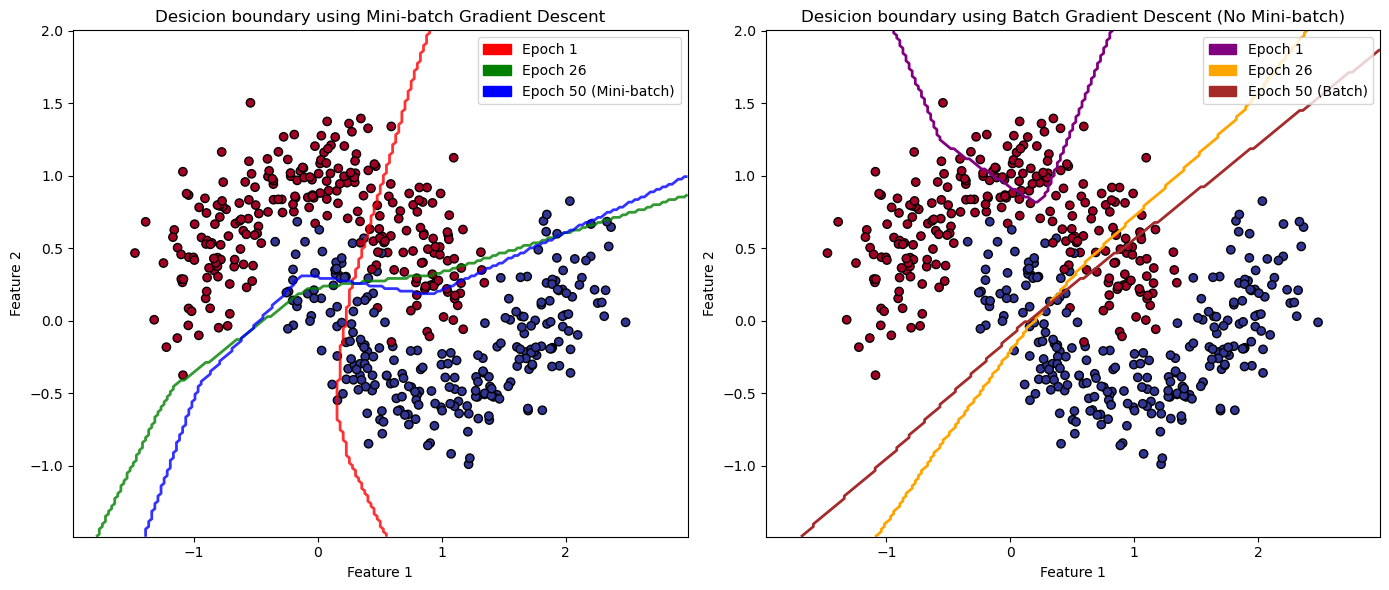

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.datasets import make_moons
import warnings
warnings.filterwarnings("ignore")

# --- Dataset ---
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
dataset_size = X.shape[0]

# --- Model ---
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 2)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# --- Grid for plotting decision boundary ---
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# --- Training parameters ---
epochs = 50

def train_model(batch_size):
    model = SimpleMLP()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    criterion = nn.CrossEntropyLoss()
    
    decision_boundaries = {}
    
    for epoch in range(epochs):
        permutation = torch.randperm(dataset_size)
        
        for i in range(0, dataset_size, batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X[indices], y[indices]
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch in [0, epochs//2, epochs-1]:
            with torch.no_grad():
                preds = model(grid).argmax(dim=1).numpy()
            decision_boundaries[epoch] = preds.reshape(xx.shape)
    return decision_boundaries

# Train with mini-batch GD
decision_minibatch = train_model(batch_size=32)

# Train with batch GD (full dataset)
decision_batch = train_model(batch_size=dataset_size)

# Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14,6))

colors_mb = {0: 'red', epochs//2: 'green', epochs-1: 'blue'}
colors_b = {0: 'purple', epochs//2: 'orange', epochs-1: 'brown'}
labels_mb = {0: 'Epoch 1', epochs//2: f'Epoch {epochs//2+1}', epochs-1: f'Epoch {epochs} (Mini-batch)'}
labels_b = {0: 'Epoch 1', epochs//2: f'Epoch {epochs//2+1}', epochs-1: f'Epoch {epochs} (Batch)'}

# Mini-batch plot
ax = axes[0]
for ep, preds in decision_minibatch.items():
    ax.contour(xx, yy, preds, levels=[0.5], colors=colors_mb[ep], alpha=0.8, linewidths=2)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k')
legend_patches = [Patch(color=colors_mb[ep], label=labels_mb[ep]) for ep in decision_minibatch.keys()]
ax.legend(handles=legend_patches)
ax.set_title("Desicion boundary using Mini-batch Gradient Descent")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

# Batch GD plot
ax = axes[1]
for ep, preds in decision_batch.items():
    ax.contour(xx, yy, preds, levels=[0.5], colors=colors_b[ep], alpha=1, linewidths=2)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k')
legend_patches = [Patch(color=colors_b[ep], label=labels_b[ep]) for ep in decision_batch.keys()]
ax.legend(handles=legend_patches)
ax.set_title("Desicion boundary using Batch Gradient Descent (No Mini-batch)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

plt.tight_layout()
plt.show()


### ⏱️ Learning Rate Scheduling

Adjusts the learning rate dynamically during training to improve convergence.

- **Step Decay**:  
  Reduces the learning rate by a fixed factor every *n* epochs.  
  Example:  
  $$
  \text{lr} = \text{initial\_lr} \times \text{drop\_factor}^{\left\lfloor \frac{\text{epoch}}{\text{step\_size}} \right\rfloor}
  $$

- **Exponential Decay**:  
  The learning rate decreases continuously:  
  $$
  \text{lr} = \text{initial\_lr} \times e^{-\text{decay\_rate} \times \text{epoch}}
  $$

- **Cosine Annealing**:  
  Decreases the learning rate following a cosine curve from max to min:  
  $$
  \text{lr}(t) = \text{min\_lr} + \frac{1}{2}(\text{max\_lr} - \text{min\_lr}) \left(1 + \cos\left(\frac{t \pi}{T}\right)\right)
  $$  
  Often used with restarts (e.g., SGDR) to escape local minima and improve convergence.


100%|██████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 9.02MB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 315kB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.97MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.08MB/s]


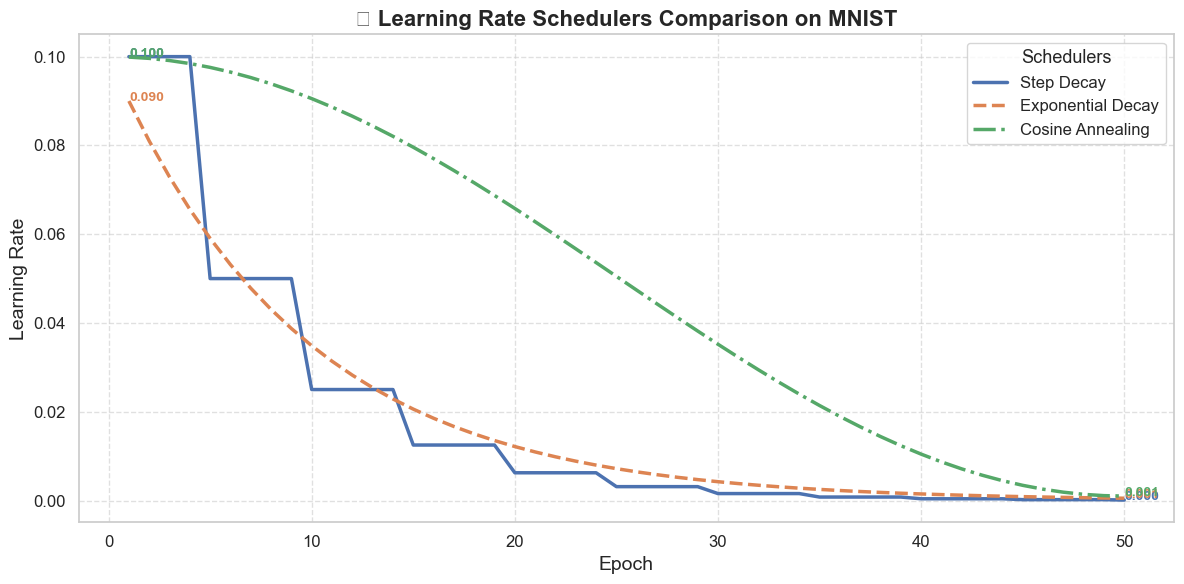

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import seaborn as sns
# ----------------------
# Load MNIST Data
# ----------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ----------------------
# Simple MLP Model
# ----------------------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

# ----------------------
# Learning Rate Schedulers
# ----------------------
def get_scheduler(optimizer, name, **kwargs):
    if name == 'step':
        return optim.lr_scheduler.StepLR(optimizer, step_size=kwargs['step_size'], gamma=kwargs['gamma'])
    elif name == 'exp':
        return optim.lr_scheduler.ExponentialLR(optimizer, gamma=kwargs['gamma'])
    elif name == 'cosine':
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kwargs['T_max'], eta_min=kwargs['min_lr'])
    else:
        raise ValueError(f"Unknown scheduler type: {name}")

# ----------------------
# Training Function
# ----------------------
def train(model, optimizer, scheduler, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    lrs = []
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
        scheduler.step()
        lrs.append(optimizer.param_groups[0]['lr'])
    return lrs

# ----------------------
# Training with Each Scheduler
# ----------------------
initial_lr = 0.1
num_epochs = 50

schedulers_config = {
    "Step Decay": {'name': 'step', 'step_size': 5, 'gamma': 0.5},
    "Exponential Decay": {'name': 'exp', 'gamma': 0.9},
    "Cosine Annealing": {'name': 'cosine', 'T_max': num_epochs, 'min_lr': 0.001}
}

results = {}

for name, config in schedulers_config.items():
    model = MLP()
    optimizer = optim.SGD(model.parameters(), lr=initial_lr)
    
    scheduler_config = config.copy()
    if scheduler_config['name'] == 'cosine':
        scheduler_config.setdefault('T_max', num_epochs)
        scheduler_config.setdefault('min_lr', 0.001)

    scheduler = get_scheduler(optimizer, **scheduler_config)
    lrs = train(model, optimizer, scheduler, num_epochs)
    results[name] = lrs

# ----------------------
# Plotting
# ----------------------
# Set Seaborn style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Color palette and line styles
colors = sns.color_palette("deep", len(results))
linestyles = ['-', '--', '-.']

for i, (name, lrs) in enumerate(results.items()):
    epochs = list(range(1, len(lrs) + 1))
    plt.plot(epochs, lrs, label=name,
             linewidth=2.5, linestyle=linestyles[i % len(linestyles)],
             color=colors[i])

    # Annotate start and end points
    plt.text(epochs[0], lrs[0], f"{lrs[0]:.3f}", fontsize=10, color=colors[i], weight='bold')
    plt.text(epochs[-1], lrs[-1], f"{lrs[-1]:.3f}", fontsize=10, color=colors[i], weight='bold')

# Title and labels
plt.title("📉 Learning Rate Schedulers Comparison on MNIST", fontsize=16, weight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Learning Rate", fontsize=14)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Schedulers", fontsize=12, title_fontsize=13, loc="upper right")

plt.tight_layout()
plt.show()


## 🧮 Evaluation Metrics

### ✅ Accuracy, Precision, Recall, F1 Score

- **Accuracy**:  
  Proportion of correctly predicted samples out of all samples.  
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **Precision**:  
  Out of all predicted positives, how many are actually positive?  
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall (Sensitivity or True Positive Rate)**:  
  Out of all actual positives, how many did we correctly predict?  
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **F1 Score**:  
  Harmonic mean of precision and recall.  
  $$
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

Where:
- **TP** = True Positives  
- **TN** = True Negatives  
- **FP** = False Positives  
- **FN** = False Negatives

---

### 📊 Confusion Matrix

A confusion matrix shows the counts of actual vs. predicted labels.

|                | **Predicted Positive** | **Predicted Negative** |
|----------------|------------------------|------------------------|
| **Actual Positive** | True Positive (TP)        | False Negative (FN)       |
| **Actual Negative** | False Positive (FP)       | True Negative (TN)        |

It helps visualize where the model is making mistakes and which classes it confuses.


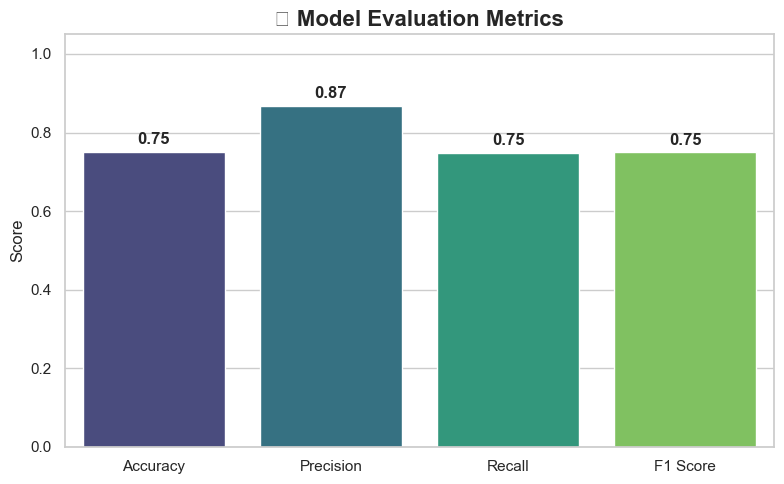

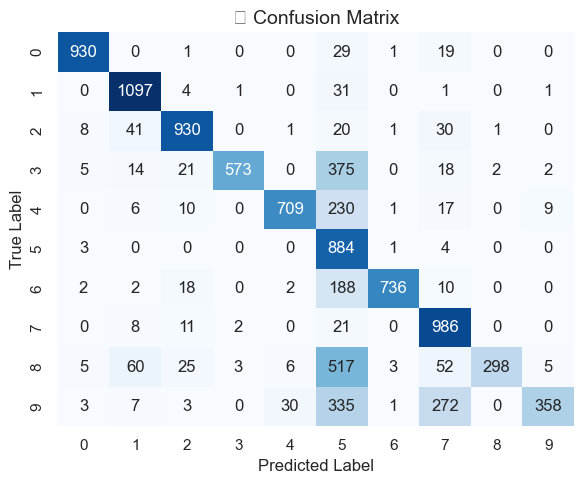

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred
    }

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred
    }
def plot_metrics(metrics):
    # Bar plot of the four key metrics
    scores = {
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1']
    }

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette='viridis')
    plt.ylim(0.0, 1.05)
    plt.title("✅ Model Evaluation Metrics", fontsize=16, weight='bold')
    plt.ylabel("Score")
    for i, v in enumerate(scores.values()):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()
def plot_confusion_matrix(cm, class_names=None):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title("📊 Confusion Matrix", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Example setup using MNIST (you can adapt this to your data)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
metrics = evaluate_model(model, test_loader)
plot_metrics(metrics)
plot_confusion_matrix(metrics['confusion_matrix'], class_names=[str(i) for i in range(10)])

## 🧪 Data Preparation

### 📏 Normalization and Standardization of Features

- **Normalization** scales features to a range, usually [0, 1].  
  Useful when features have different units or ranges.
  $$
  x_{\text{norm}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
  $$

- **Standardization** centers features around the mean with unit variance.  
  Often used in models that assume Gaussian distributions (e.g., logistic regression, SVM).
  $$
  x_{\text{std}} = \frac{x - \mu}{\sigma}
  $$
  Where \( \mu \) is the mean and \( \sigma \) is the standard deviation.



100%|██████████████████████████████████████| 2.64G/2.64G [03:32<00:00, 12.4MB/s]


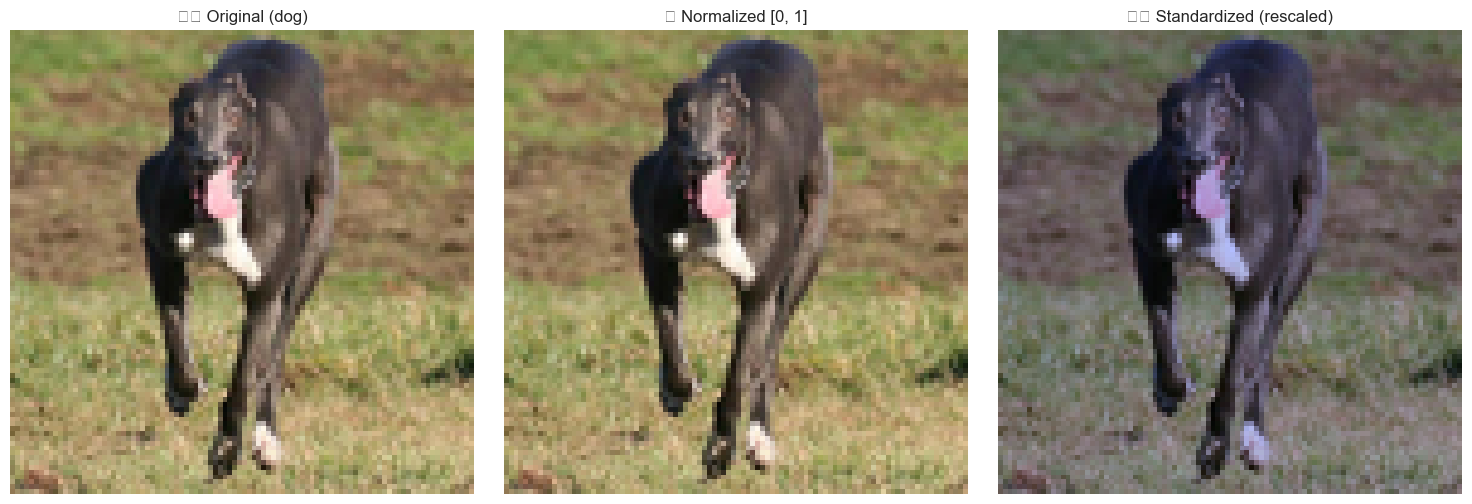

In [9]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import STL10
import matplotlib.pyplot as plt
import numpy as np

# 📥 Load STL10 (higher-res natural images)
transform = transforms.ToTensor()
stl10 = STL10(root='.', split='train', download=True, transform=transform)

# Select a visually rich image (e.g., airplane, ship, monkey)
img_tensor, label = stl10[1]
label_name = stl10.classes[label]

# Convert to numpy for manipulation
img = img_tensor.permute(1, 2, 0).numpy()  # shape: (96, 96, 3)
img_orig = (img * 255).astype(np.uint8)

# ✅ Normalization (already in [0, 1] due to ToTensor)
img_norm = img  # [0, 1]

# ✅ Standardization
mean = img.mean(axis=(0, 1))
std = img.std(axis=(0, 1))
img_std = (img * 255 - mean) / std

# 🔁 Rescale standardized image to [0, 1] for display
img_std_rescaled = (img_std - img_std.min()) / (img_std.max() - img_std.min())

# 📊 Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_orig)
axes[0].set_title(f'🖼️ Original ({label_name})')
axes[0].axis('off')

axes[1].imshow(img_norm)
axes[1].set_title('🔁 Normalized [0, 1]')
axes[1].axis('off')

axes[2].imshow(img_std_rescaled)
axes[2].set_title('⚖️ Standardized (rescaled)')
axes[2].axis('off')

plt.tight_layout()
plt.show()



### 🧾 One-hot Encoding for Categorical Targets

- Transforms categorical variables into a binary vector for each class.  
  For example, a label "cat" in ["cat", "dog", "mouse"] becomes:
  $$
  [1, 0, 0]
  $$

- Essential for classification tasks using neural networks.

---


### 🖼️ Data Augmentation

- Used to artificially expand the dataset by applying transformations.  
  Particularly helpful for image, audio, or time series data.

- Examples of augmentations:
  - Images: rotation, flipping, cropping, color jitter
  - Time series: jittering, window slicing, warping

- Helps reduce overfitting and improve generalization.

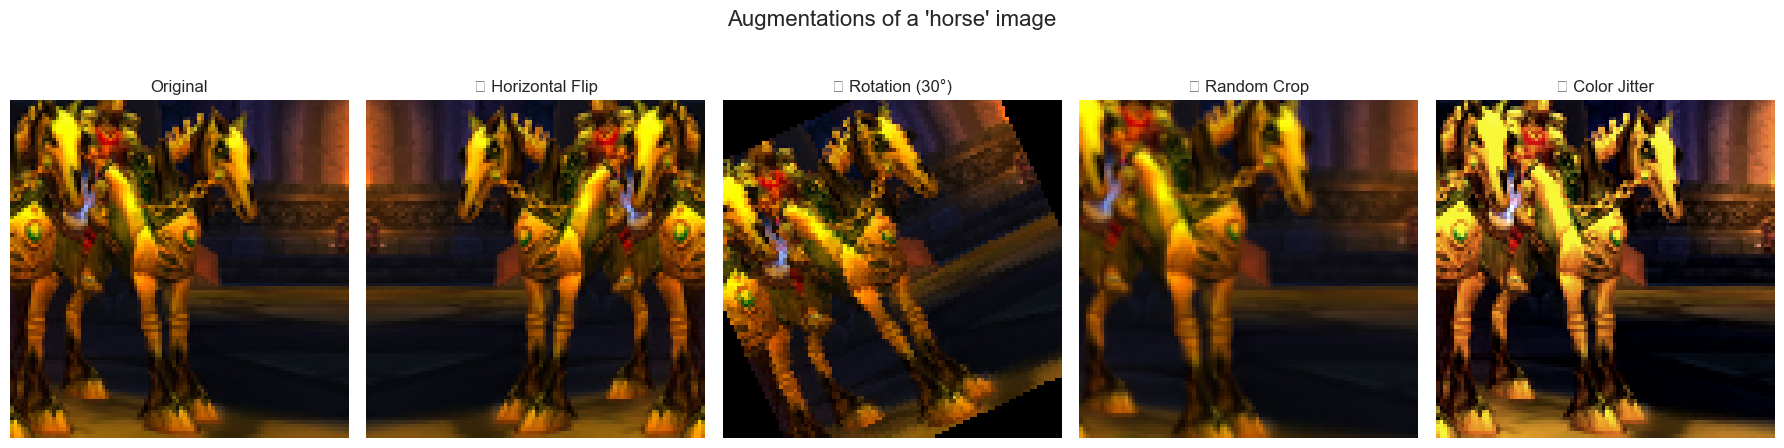

In [11]:
import torch
from torchvision import transforms
from torchvision.datasets import STL10
import matplotlib.pyplot as plt

# 📥 Load STL10 dataset
dataset = STL10(root='.', split='train', download=True, transform=transforms.ToTensor())
image, label = dataset[3]  # Pick a visually distinct sample
label_name = dataset.classes[label]

# Define augmentations
augmentations = {
    "Original": transforms.Compose([]),
    "🔁 Horizontal Flip": transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0)
    ]),
    "🔄 Rotation (30°)": transforms.Compose([
        transforms.RandomRotation(degrees=30)
    ]),
    "🔲 Random Crop": transforms.Compose([
        transforms.RandomResizedCrop(size=96, scale=(0.6, 1.0))
    ]),
    "🎨 Color Jitter": transforms.Compose([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)
    ]),
}

# Apply and visualize
fig, axes = plt.subplots(1, len(augmentations), figsize=(18, 5))

for ax, (name, aug) in zip(axes, augmentations.items()):
    # Apply transform
    transform = transforms.Compose([aug, transforms.ToTensor()])
    img_aug = transform(transforms.ToPILImage()(image))
    
    # Convert for display
    img_np = img_aug.permute(1, 2, 0).numpy()
    
    ax.imshow(img_np)
    ax.set_title(name)
    ax.axis('off')

plt.suptitle(f"Augmentations of a '{label_name}' image", fontsize=16)
plt.tight_layout()
plt.show()



## 🧠 Computational Graphs and Autograd

### 1. Computational Graph 🧩

A **computational graph** is a directed acyclic graph (DAG) where:

- **Nodes** represent operations or variables (tensors).  
- **Edges** represent data dependencies, showing how data flows through operations.

This graph encodes the sequence of computations and is essential for calculating gradients via **backpropagation**. 🔄

---

### 2. Dynamic Computation Graphs (PyTorch) ⚡️

- **Definition**: Also called **define-by-run**, the computational graph is **constructed dynamically** during the **forward pass** as operations execute.
- **Key properties**:
  - The graph is **rebuilt from scratch** at every iteration or forward pass. 🔄
  - Enables **dynamic control flow** such as loops and conditional statements that depend on runtime values. 🔁
  - Highly **flexible and intuitive** for prototyping and models with variable-length inputs (e.g., RNNs with varying sequence lengths). 🧪
- **Autograd**:
  - PyTorch's autograd engine records the operations applied to tensors with `requires_grad=True` on-the-fly. 📋
  - When `.backward()` is called, it traverses this dynamically built graph in reverse to compute gradients. 🔙


### 3. Static Computation Graphs (TensorFlow 1.x, and Graph mode) 🏗️

- **Definition**: Also called **define-and-run**, the computational graph is **pre-defined and fixed** before running the model.
- **Key properties**:
  - You first **declare the entire computation graph** (all operations and variables). 📝
  - The graph is then **compiled** and **executed** multiple times with different inputs. 🚀
  - This separation allows optimizations like graph-level transformations and more efficient deployment. ⚙️
  - Less flexible with dynamic control flow unless specialized constructs (`tf.while_loop`, `tf.cond`) are used. 🔒
- **Autograd**:
  - Gradients are computed symbolically using the pre-built graph. 🔣
  - Backpropagation is performed by traversing the static graph. ↩️
- **Example** (TensorFlow 1.x style):

### 4. Summary Comparison 📊

| Feature                 | Dynamic Graph (PyTorch) ⚡️                      | Static Graph (TensorFlow 1.x) 🏗️                 |
|-------------------------|-------------------------------------------------|--------------------------------------------------|
| Graph construction      | Built at runtime (define-by-run) 🔄             | Built before execution (define-and-run) 📝        |
| Flexibility             | High (supports dynamic control flow easily) 🔁 | Limited (control flow requires special ops) 🔒   |
| Debugging               | Easier (can use standard Python debugging) 🐞   | Harder (graph is separate from code execution) 🔍|
| Performance optimization| Limited to runtime optimizations ⚙️             | Advanced static graph optimizations possible 🚀   |
| Use case                | Research, prototyping, dynamic models 🧪        | Production, deployment, static workloads 🏭       |
